In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import parameters
import pandas as pd
import seaborn as sns
from IPython.display import Image
import itertools
marker = itertools.cycle((',', '+', '.', 'o', '*'))

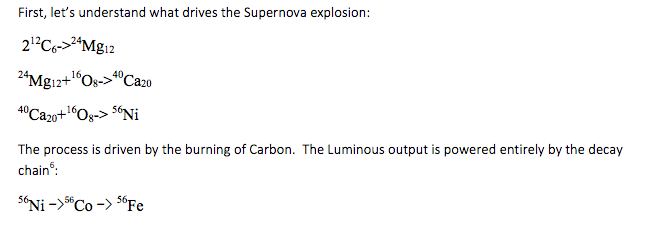

In [2]:
Image(filename=parameters.imgAddress + 'CarbonFusionNuclearReaction.png')

# Volumetric Model

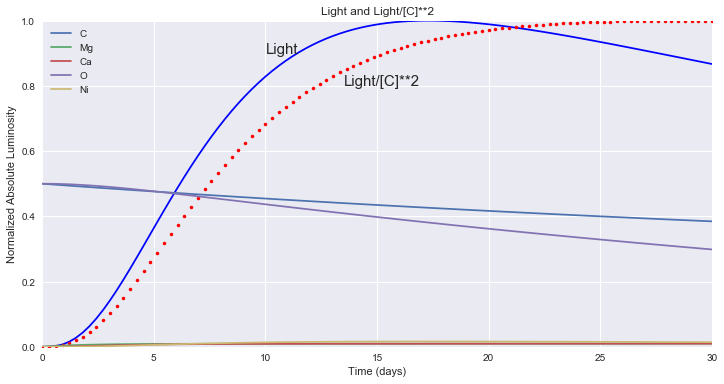

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
fig.subplots_adjust(hspace=.4)

def rxn(C,t):
    # Reaction rates
    kmg=0.02
    kca=1
    kni=1
    knidecay=0.22
    ##############
    carbon0=C[0]
    mg0=C[1]
    ca0=C[2]
    ox0=C[3]
    ni0=C[4]
    light=C[5]
    # Light = kLight*[Ni] = kLight*dnidt*deltaT 
    # assuming constant dnidt and contanst deltaT - this is the coasting velocity approximation
    # dcarbondt=-kmg*[C][C]
    dcarbdt=-kmg*carbon0**2
    
    # dMgdt=kmg*[C][C]-kca*[Mg][O]
    dmgdt=kmg*carbon0**2-kca*mg0*ox0
    
    # dCadt=kca*[Mg]*[O]-kni*[Ca][0]
    dcadt=kca*mg0*ox0-kni*ca0*ox0
    
    #doxdt=-kca*mg0*ox0-kni*ca0*ox0
    doxdt=-kca*mg0*ox0-kni*ca0*ox0
    
    # dNidt=kni*[Ca][O]-klight*[Ni]
    dnidt=kni*ca0*ox0-knidecay*ni0
    
    dlightdt=dnidt
    return [dcarbdt,dmgdt,dcadt,doxdt,dnidt,dlightdt]

t=np.linspace(0,30,100)
C0=[0.5,0.0,0.0,0.5,0.0,0.0]
delay=0.0
cc=pd.DataFrame(odeint(rxn,C0,t), index=t, columns=['C','Mg','Ca','O','Ni','Light'])
goodnessOfApproximation=(cc.Light/cc.C**2)
goodnessOfApproximation.index= goodnessOfApproximation.index-delay
goodnessOfApproximation=goodnessOfApproximation/goodnessOfApproximation.max()
light=cc.Light/cc.Light.max()
light.columns=['light']
light.plot(ax=axes, style='b-')
xmax=30
xdiff=8
goodnessOfApproximation.plot(ax=axes,style='r.', xlim=[0,xmax],ylim=[0,1])
goodnessOfApproximation.columns=['light/[C]^2']
cc[[0,1,2,3,4]].plot(ax=axes, xlim=[0,xmax],ylim=[0,1], legend=True)

plt.xlabel('Time (days)')
plt.ylabel('Normalized Absolute Luminosity')
plt.title('Light and Light/[C]**2')
plt.text(2.0+xdiff, 0.9, r'Light', fontsize=15)
plt.text(5.5+xdiff, 0.8, r'Light/[C]**2', fontsize=15)
# plt.axhline(y=0.94, xmin=0, xmax=1, hold=None)
plt.show()

parameters.saveme=True

if parameters.saveme:
    fig.savefig(parameters.imgAddress + 'LightPerCarbonSquared.png', dpi=300)
    
# i


# Shockwave Model

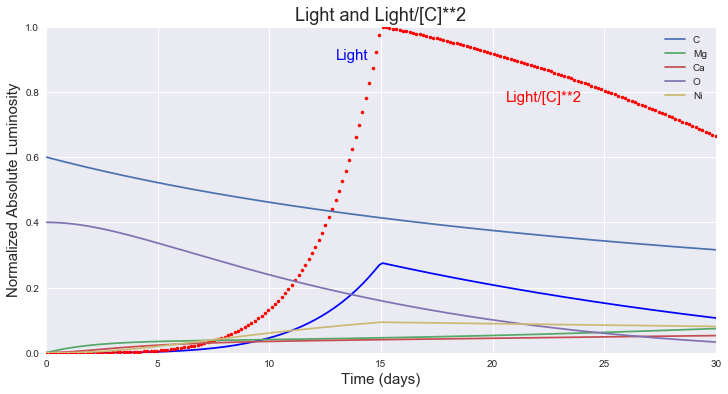

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
fig.subplots_adjust(hspace=.4)

def rxn(C,t,rc=1.0):
    # Chandrasekhar radius
    vel= rc/15 # 15 days to reach White Dwarf Surface
    tc=15
    # Reaction rates
    kmg=0.05
    kca=1
    kni=1
    knidecay=0.01
    # Diffusion process with two rates 0.3 for radiation created before the shockwave 
    # reaches surface and 0.03 for radiation diffusion across ejecta
    kdiff=0.3*(t<tc)-0.03*(t>tc)
    ##############
    carbon0=C[0]
    mg0=C[1]
    ca0=C[2]
    ox0=C[3]
    ni0=C[4]
    light=C[5]
    # Light = kLight*[Ni] = kLight*dnidt*deltaT 
    # assuming constant dnidt and contanst deltaT - this is the coasting velocity approximation
    # dcarbondt=-kmg*[C][C]
    dcarbdt=-kmg*carbon0**2
    
    # dMgdt=kmg*[C][C]-kca*[Mg][O]
    dmgdt=kmg*carbon0**2-kca*mg0*ox0
    
    # dCadt=kca*[Mg]*[O]-kni*[Ca][0]
    dcadt=kca*mg0*ox0-kni*ca0*ox0
    
    #doxdt=-kca*mg0*ox0-kni*ca0*ox0
    doxdt=-kca*mg0*ox0-kni*ca0*ox0
    
    # dNidt=kni*[Ca][O]-klight*[Ni]
    # We consider Calcium + Oxigen fusion to take place only until the shockwave reaches surface
    # knidecay refers to the decay Ni->Co->Fe
    dnidt=kni*ca0*ox0*(t<tc)-knidecay*ni0
    # Light is created as the shockwave progresses. The accumulated light is supposed
    # to travel with the shockwave. It corresponds to the integral of the light along the radial line
    # is integrate(0,t,dnidt*dt)= dnidt*t
    # For t>tc, the Ni density reaches a limit of dnidt*tc
    dlightdt=dnidt*(1+ t*(t<tc)+tc*(t>tc))*np.exp(-kdiff*(tc-t))
    
    return [dcarbdt,dmgdt,dcadt,doxdt,dnidt,dlightdt]
tc=15
t=np.linspace(0,30,200)
C0=[0.6,0.0,0.0,0.4,0.0,0.0]
delay=0
cc=pd.DataFrame(odeint(rxn,C0,t), index=t, columns=['C','Mg','Ca','O','Ni','Light'])
goodnessOfApproximation=(cc.Light/cc.C**2)
goodnessOfApproximation.index= goodnessOfApproximation.index-delay
goodnessOfApproximation=goodnessOfApproximation/goodnessOfApproximation.max()
light=cc.Light
light.columns=['light']
light.plot(ax=axes, style='b-')
xmax=30
xdiff=12.0
goodnessOfApproximation.plot(ax=axes,style='r.', xlim=[0,xmax],ylim=[0,1])
goodnessOfApproximation.columns=['light/[C]^2']
cc[[0,1,2,3,4]].plot(ax=axes, xlim=[0,xmax],ylim=[0,1], legend=True)

plt.xlabel('Time (days)',fontsize=15,)
plt.ylabel('Normalized Absolute Luminosity',fontsize=15,)
plt.title('Light and Light/[C]**2',fontsize=18,)
plt.text(1.0+xdiff, 0.9, r'Light', fontsize=15, color='blue')
plt.text(8.6+xdiff, 0.77, r'Light/[C]**2', fontsize=15, color='red')
# plt.axhline(y=0.94, xmin=0, xmax=1, hold=None)
plt.show()

parameters.saveme=True

if parameters.saveme:
    fig.savefig(parameters.imgAddress + 'LightPerCarbonSquaredShockwave.png', dpi=300)


# Arnett 
http://adsabs.harvard.edu/abs/1989ApJ...340..396A
The Late Bahavior of Supernova 1987A. The Light Curve


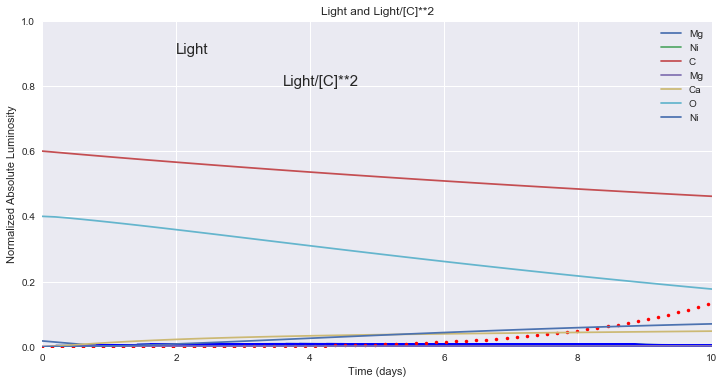

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
fig.subplots_adjust(hspace=.4)

def rxn(C,t):
    # Reaction rates
    kmg=0.05
    kca=20
    kni=1
    knidecay=0.05
    ##############
    carbon0=C[0]
    mg0=C[1]
    ca0=C[2]
    ox0=C[3]
    ni0=C[4]
    light=C[5]
    # Light = kLight*[Ni] = kLight*dnidt*deltaT 
    # assuming constant dnidt and contanst deltaT - this is the coasting velocity approximation
    # dcarbondt=-kmg*[C][C]
    dcarbdt=-kmg*carbon0**2
    
    # dMgdt=kmg*[C][C]-kca*[Mg][O]
    dmgdt=kmg*carbon0**2-kca*mg0*ox0
    
    # dCadt=kca*[Mg]*[O]-kni*[Ca][0]
    dcadt=kca*mg0*ox0-kni*ca0*ox0
    
    #doxdt=-kca*mg0*ox0-kni*ca0*ox0
    doxdt=-kca*mg0*ox0-kni*ca0*ox0
    
    # dNidt=kni*[Ca][O]-klight*[Ni]
    dnidt=kni*ca0*ox0-knidecay*ni0
    
    dlightdt=dnidt
    return [dcarbdt,dmgdt,dcadt,doxdt,dnidt,dlightdt]

t=np.linspace(0,20,100)
C0=[0.6,0.0,0.0,0.4,0.0,0.0]
delay=0
cc=pd.DataFrame(odeint(rxn,C0,t), index=t, columns=['C','Mg','Ca','O','Ni','Light'])


# Calculate derivatives of Light and Mg for all those times.

der={}
for i in range(len(t)):
    tt=t[i]
    ccc=cc.iloc[i]
    der[tt]= rxn(ccc,tt)
der=pd.DataFrame.from_dict(der,orient='index')
der.columns=['C','Mg','Ca','O','Ni','Light']
derLight= der.loc[:,'Light']
derMg = der.loc[:,'Mg']
              
der.plot(ax=axes,y=['Mg','Ni'], ylim=[0,0.01])

goodnessOfApproximation=goodnessOfApproximation/goodnessOfApproximation.max()
light=cc.Light/cc.Light.max()
light.columns=['light']
derLight.plot(ax=axes, style='b-')
xmax=10
xdiff=0
goodnessOfApproximation.plot(ax=axes,style='r.', xlim=[0,xmax],ylim=[0,1])
goodnessOfApproximation.columns=['light/[C]^2']
cc[[0,1,2,3,4]].plot(ax=axes, xlim=[0,xmax],ylim=[0,1], legend=True)

plt.xlabel('Time (days)')
plt.ylabel('Normalized Absolute Luminosity')
plt.title('Light and Light/[C]**2')
plt.text(2.0+xdiff, 0.9, r'Light', fontsize=15)
plt.text(3.6+xdiff, 0.8, r'Light/[C]**2', fontsize=15)
# plt.axhline(y=0.94, xmin=0, xmax=1, hold=None)
plt.show()

parameters.saveme=True

if parameters.saveme:
    fig.savefig(parameters.imgAddress + 'LightPerCarbonSquared.png', dpi=300)


In [7]:
der

,C,Mg,Ca,O,Ni,Light
0.000000,-0.018000,1.800000e-02,0.000000,-0.000000,0.000000,0.000000
1.010101,-0.016957,4.322738e-08,0.011990,-0.021923,0.004847,0.004847
2.020202,-0.016002,2.072947e-05,0.007799,-0.024163,0.007736,0.007736
3.434343,-0.014794,4.810609e-05,0.004608,-0.024885,0.009084,0.009084
4.040404,-0.014318,5.814303e-05,0.003809,-0.024711,0.009120,0.009120
5.050505,-0.013575,7.410627e-05,0.002929,-0.024072,0.008787,0.008787
6.060606,-0.012888,9.032798e-05,0.002418,-0.023177,0.008166,0.008166
7.676768,-0.011892,1.184992e-04,0.002040,-0.021506,0.006909,0.006909
8.080808,-0.011661,1.264068e-04,0.001999,-0.021070,0.006575,0.006575
9.090909,-0.011112,1.482184e-04,0.001958,-0.019970,0.005735,0.005735


# Modified Shockwave Model

ValueError: cannot evaluate a numeric op with unequal lengths

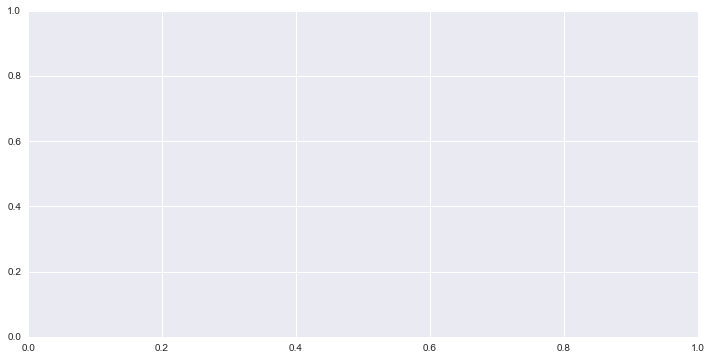

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
fig.subplots_adjust(hspace=.4)

def rxn(C,t,tc=10):
    # Chandrasekhar radius
    # Reaction rates
    kmg=0.05
    kca=1
    kni=1
    knidecay=50

    ##############
    carbon0=C[0]
    mg0=C[1]
    ca0=C[2]
    ox0=C[3]
    ni0=C[4]
    # Light = kLight*[Ni] = kLight*dnidt*deltaT 
    # assuming constant dnidt and contanst deltaT - this is the coasting velocity approximation
    # dcarbondt=-kmg*[C][C]
    dcarbdt=-kmg*carbon0**2
    
    # dMgdt=kmg*[C][C]-kca*[Mg][O]
    dmgdt=kmg*carbon0**2-kca*mg0*ox0
    
    # dCadt=kca*[Mg]*[O]-kni*[Ca][0]
    dcadt=kca*mg0*ox0-kni*ca0*ox0
    
    #doxdt=-kca*mg0*ox0-kni*ca0*ox0
    doxdt=-kca*mg0*ox0-kni*ca0*ox0
    
    # dNidt=kni*[Ca][O]-klight*[Ni]
    # We consider Calcium + Oxigen fusion to take place only until the shockwave reaches surface
    # knidecay refers to the decay Ni->Co->Fe
    dnidt=kni*ca0*ox0*(t<tc)-knidecay*ni0
    # Light is created as the shockwave progresses. The accumulated light is supposed
    # to travel with the shockwave. It corresponds to the integral of the light along the radial line
    # is integrate(0,t,dnidt*dt)= dnidt*t
    # For t>tc, the Ni density reaches a limit of dnidt*tc
    return [dcarbdt,dmgdt,dcadt,doxdt,dnidt]

def getLight(Ni,tc):
    # Diffusion process with two rates 0.3 for radiation created before the shockwave 
    # reaches surface and 0.03 for radiation diffusion across ejecta
    t=Ni.index
    kNidecay=0.1
    kdiff=0.3*(t<tc)
    deepPhotons={}
    for tt in t:
        if tt<=tc:
            deepPhotons[tt]=np.sum(kNidecay*Ni[Ni.index<=tt]*t[t<tt]**2)
        else:
            deepPhotons[tt]=np.sum(kNidecay*Ni[Ni.index<=tc]*t[t<tc]**2)*np.exp(-kdiff*(tt-tc))
    photons=pd.DataFrame.from_dict(deepPhotons,orient='index')
    return photons
    

t=np.linspace(0,30,200)
C0=[0.5,0.0,0.0,0.5,0.0]
goodnessOfApproximation={}
for tc in range(10,5,-1):
    tcc=t[np.argmin(np.abs(t - tc))]
    cc=pd.DataFrame(odeint(rxn,C0,t,(tcc,)), index=t, columns=['C','Mg','Ca','O','Ni'])
    goodnessOfApproximation[tc]=getLight(cc.Ni,tcc)/(tcc/10.0)**(3)

goodnessOfApproximation=pd.DataFrame.from_dict(goodnessOfApproximation,orient='index')
goodnessOfApproximation=goodnessOfApproximation/goodnessOfApproximation.max()
goodnessOfApproximation.columns=['Approximation']
goodnessOfApproximation.plot(ax=axes)    

cc=pd.DataFrame(odeint(rxn,C0,t), index=t, columns=['C','Mg','Ca','O','Ni'])

xmax=30
xdiff=0.0
cc[[0,1,2,3,4]].plot(ax=axes, xlim=[0,xmax],ylim=[0,1.0], legend=True)
plt.xlabel('Time (days)',fontsize=15,)
plt.ylabel('Normalized Absolute Luminosity',fontsize=15,)
plt.title('Light and Light/[C]**2',fontsize=18,)
# plt.text(1.0+xdiff, 0.9, r'Light', fontsize=15, color='blue')
# plt.text(8.6+xdiff, 0.77, r'Light/[C]**2', fontsize=15, color='red')
# plt.axhline(y=0.94, xmin=0, xmax=1, hold=None)
plt.show()

parameters.saveme=True

if parameters.saveme:
    fig.savefig(parameters.imgAddress + 'LightPerCarbonSquaredShockwave.png', dpi=300)


In [ ]:
rxn(cc.loc[tc],tc,tc)[4]